In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt

1 Gaussian and Laplacian Pyramids

In class we described the Gaussian pyramid constructed using the REDUCE operator. On the class website’s Problem Sets main page there is a link to the original Burt and Adelson Laplacian Pyramid paper that defines the REDUCE and EXPAND operators. And it’s in the main directory given above.

1.1 Write a function to implement REDUCE. Use this to produce a Gaussian Pyramid of 4 levels (0-3). Demonstrate using the first frame of the DataSeq1 sequence.

Output: The code, and the 4 images that make up the Gaussian Pyramid

In [2]:
seq1_imgs = []
for img in glob.glob(r'./images/DataSeq1/*.jpg'):
    seq1_imgs.append(cv2.imread(img, cv2.COLOR_BGR2GRAY))

In [3]:
def img_reduce(img):
    height, width = img.shape
    out_img = img.copy()
    kernel = np.array([1, 4, 6, 4, 1]) / 16
    out_img = cv2.sepFilter2D(out_img, ddepth=-1, kernelX=kernel, kernelY=kernel)
    out_img = out_img[::2, ::2]
    return out_img

In [4]:
def pyramid_reduce(img, level=4):
    reduces = [img.copy()] * level
    for i in range(1, level):
        reduces[i] = img_reduce(reduces[i-1])
    return reduces

In [5]:
img1_pyramid_reduces = pyramid_reduce(seq1_imgs[0])

In [6]:
for i in range(4):
    cv2.imwrite('ps5-1-1-{}.png'.format(i+1), img1_pyramid_reduces[i])

![ps5-1-1-1](./ps5-1-1-1.png)
![ps5-1-1-2](./ps5-1-1-2.png)
![ps5-1-1-3](./ps5-1-1-3.png)
![ps5-1-1-4](./ps5-1-1-4.png)

Although the Lucas and Kanade method does not use the Laplacian Pyramid, you do need to expand the warped coarser levels (more on this in a minute). Therefore you will need to implement the EXPAND operator. Once you have that the Laplacian Pyramid is just some subtractions.

1.2 Write the function EXPAND. Using it and the above REDUCE, create the 4 level Laplacian pyramid of DataSeq1 (which has 1 Gaussian image and the 3 Laplacian images).

Output: The code and the Laplacian pyramid images (3 Laplacian images and 1 Gaussian image) of the first image of DataSeq1.

In [7]:
def img_expand(img, target_img):
    height, width = img.shape
    out_img = np.zeros((2*height, 2*width))
    
    kernel = np.array([1, 4, 6, 4, 1]) / 16
    kernel_even = np.array([1, 1]) / 2
    out_img[::2, ::2] = cv2.sepFilter2D(img, ddepth=-1, kernelX=kernel, kernelY=kernel)
    out_img[::2, 1::2] = cv2.sepFilter2D(img, ddepth=-1, kernelX=kernel, kernelY=kernel_even)
    out_img[1::2, 1::2] = cv2.sepFilter2D(img, ddepth=-1, kernelX=kernel_even, kernelY=kernel_even)
    out_img[1::2, ::2] = cv2.sepFilter2D(img, ddepth=-1, kernelX=kernel_even, kernelY=kernel)
    out_h, out_w = target_img.shape
    out_img = out_img[:out_h, :out_w]
    return out_img

In [8]:
def build_gaussian_pyramid(img, level=4, full=True):
    reduces = [img.copy()] * level
    expands = []
    laplacians = []
    for i in range(1, level):
        reduces[i] = img_reduce(reduces[i-1])
        expands.append(img_expand(reduces[i], reduces[i-1]))
    for i in range(level - 1):
        laplacians.append(reduces[i] - expands[i])
    if full:
        return reduces, expands, laplacians
    else:
        return reduces[-1], laplacians

In [10]:
img1_pyramid_reduces, img1_pyramid_expands, img1_pyramid_laplacians= build_gaussian_pyramid(seq1_imgs[0], full=True)

In [11]:
cv2.imwrite('ps5-1-2-1.png', img1_pyramid_reduces[-1])
for i in range(3):
    cv2.imwrite('ps5-1-2-{}.png'.format(i+2), img1_pyramid_laplacians[i])

![ps5-1-2-2](./ps5-1-2-2.png)
![ps5-1-2-3](./ps5-1-2-3.png)
![ps5-1-2-4](./ps5-1-2-4.png)
![ps5-1-2-1](./ps5-1-2-1.png)

2 Lucas Kanade optic flow

Next you need to implement the basic LK step. Given the two operators above and code to create gradient images (you did those last problem set) you can implement the Lucas and Kanade optic flow algorithm. Recall that we compute the gradients Ix and Iy and then over a window centered around each pixel we solve the following:

    |SUM(IxIx) SUM(IxIy)| |u| = |− SUM(IxIt)|
    |SUM(IxIy) SUM(IyIy)| |v| = |− SUM(IyIt)|

Remember a weighted sum could be computed by just filtering the gradient image (or the gradient squared or product of the two gradients) by a funciton like a 5x5 box filter or a 5x5 smoothing filter (wide Gaussian) instead of actually looping. Convolution is just a normalized sum.

In [12]:
test_origin = cv2.imread('./images/TestSeq/Shift0.png')
test_origin = cv2.cvtColor(test_origin, cv2.COLOR_BGR2GRAY)
test_shiftR2 = cv2.imread('./images/TestSeq/ShiftR2.png', cv2.COLOR_BGR2GRAY)
test_shiftR2 = cv2.cvtColor(test_shiftR2, cv2.COLOR_BGR2GRAY)
test_shiftR5U5 = cv2.imread('./images/TestSeq/ShiftR5U5.png', cv2.COLOR_BGR2GRAY)
test_shiftR5U5 = cv2.cvtColor(test_shiftR5U5, cv2.COLOR_BGR2GRAY)

2.1 Write the code to do the LK optic flow estimation. For each pixel you solve the equation above. You can display the recovered values a variety of ways. The easiest is to make two new images U and V that are the x and y displacements [u(x,y) and v(x,y)]. These are displacement images. You can also use the MATLAB quiver function which draws little arrows - though you may have to scale the values to see the arrows. TestSeq has images of a smoothed image texture with the different texture center rectangle displaced by a set number of pixels. Shift0 is the “base” image; images listed as ShiftR2 have the center portion shifted to the right by 2 pixels; ShiftR5U5 have the center portion shifted to the right by 2 pixels and up 5, etc.

When you try your code on the images TestSeq you should get a simple translating rectangle in the middle and everything else zero. Try your LK on the base image and the ShiftR2 and between the base image and ShiftR5U5. Remember LK only works for small displacements with respect to the gradients so you might have to smooth your images a little to get it to work; try to find a blur amount that works for both cases but keep it as little as possible.

Output: The code and the images showing the x and y displacements either as images (make sure you scale them so you can see the values) or as arrows when computing motion between (1) the base and ShiftR2 and (2) the base and ShiftR5U5. If you blur (smooth) the images say how much you did.

In [13]:
def find_x_gradient(img):
    gradient = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
    r = np.max(gradient) - np.min(gradient)
    gradient = 255 * (gradient - np.min(gradient)) / r
    return gradient

def find_y_gradient(img):
    gradient = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
    r = np.max(gradient) - np.min(gradient)
    gradient = 255 * (gradient - np.min(gradient)) / r
    return gradient

In [14]:
def LK(img1, img2, win_size=5):
    img1_blur = cv2.GaussianBlur(img1, (5, 5), 0)
    img2_blur = cv2.GaussianBlur(img2, (5, 5), 0)
    height, width = img1.shape
    u = np.zeros((height, width))
    v = np.zeros((height, width))
    x_gradient = find_x_gradient(img1_blur)
    y_gradient = find_y_gradient(img2_blur)
    t = (img2_blur - img1_blur) 
    for iy in range(height - win_size + 1):
        for ix in range(width - win_size + 1):
            Ixx = x_gradient[iy:iy+win_size, ix:ix+win_size] ** 2
            Ixx = Ixx.sum()
            Iyy = y_gradient[iy:iy+win_size, ix:ix+win_size] ** 2 
            Iyy = Iyy.sum()
            Ixy = x_gradient[iy:iy+win_size, ix:ix+win_size] * y_gradient[iy:iy+win_size, ix:ix+win_size] 
            Ixy = Ixy.sum()
            Ixt = x_gradient[iy:iy+win_size, ix:ix+win_size] * t[iy:iy+win_size, ix:ix+win_size] 
            Ixt = Ixt.sum()
            Iyt = y_gradient[iy:iy+win_size, ix:ix+win_size] * t[iy:iy+win_size, ix:ix+win_size]
            Iyt = Iyt.sum()
            A = np.array([[Ixx, Ixy], [Ixy, Iyy]])
            b = np.array([Ixt, Iyt])
            u[iy, ix], v[iy, ix] = np.linalg.lstsq(A, b)[0]
    return u, v

In [18]:
def LK_image(img1, img2, n1=1, n2=1, win_size=5):
    u, v = LK(img1, img2, win_size=win_size)
    out_img = img1.copy()
    out_img = cv2.cvtColor(out_img, cv2.COLOR_GRAY2BGR)
    fig, ax = plt.subplots(1, figsize=(10,10))
    ax.imshow(out_img)
    X = np.arange(0, img1.shape[1])
    Y = np.arange(0, img1.shape[0])
    ax.quiver(X[::5], Y[::5], u[::5, ::5], v[::5, ::5], color='g')
    plt.savefig('ps5-2-{}-{}.png'.format(n1, n2))

/Users/sifeili/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


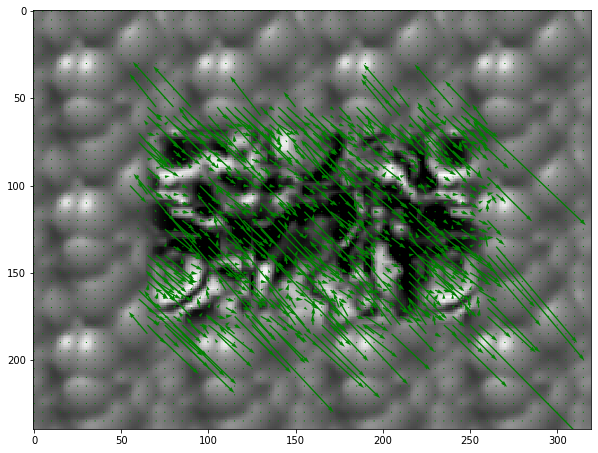

In [19]:
LK_image(test_origin, test_shiftR2, 1, 1, 5)

/Users/sifeili/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


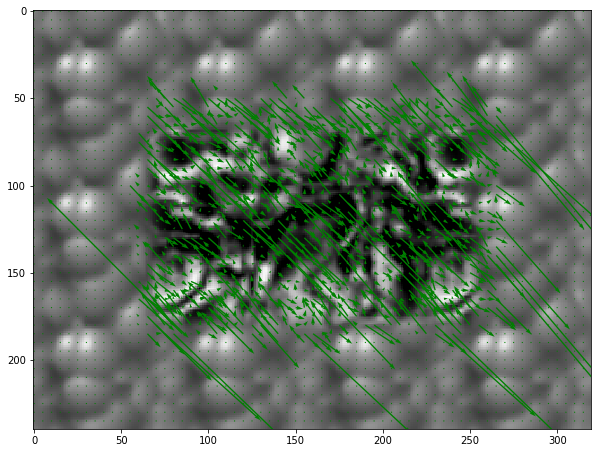

In [20]:
LK_image(test_origin, test_shiftR5U5, 1, 2, 5)

Gaussian kernel: (5, 5), sigma:0

2.2 Now try the code comparing the base image Shift0 with the remaining images of ShiftR10, ShiftR20 and ShiftR40. Use the same amount of blurring as you did in the previous section. Does it still work? Does it fall apart on any of the pairs?

Output: The code and the images showing the x and y displacements either as images or as arrows when applied to ShiftR10, ShiftR20 and ShiftR40. Describe your results.

In [21]:
test_shiftR10 = cv2.imread('./images/TestSeq/ShiftR10.png')
test_shiftR10 = cv2.cvtColor(test_shiftR10, cv2.COLOR_BGR2GRAY)
test_shiftR20 = cv2.imread('./images/TestSeq/ShiftR20.png', cv2.COLOR_BGR2GRAY)
test_shiftR20 = cv2.cvtColor(test_shiftR20, cv2.COLOR_BGR2GRAY)
test_shiftR40 = cv2.imread('./images/TestSeq/ShiftR40.png', cv2.COLOR_BGR2GRAY)
test_shiftR40 = cv2.cvtColor(test_shiftR40, cv2.COLOR_BGR2GRAY)

/Users/sifeili/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


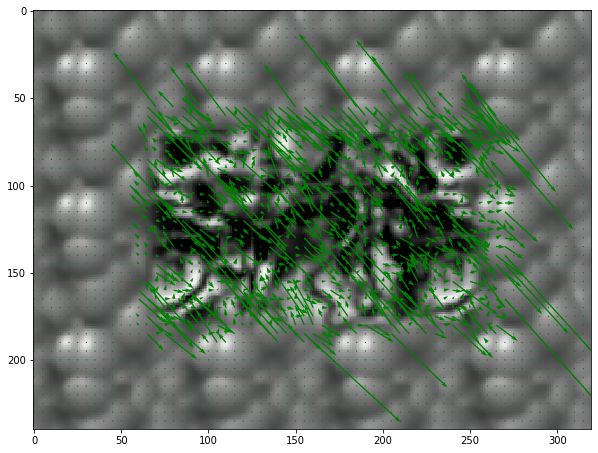

In [28]:
LK_image(test_origin, test_shiftR10, 2, 1, 5)

/Users/sifeili/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


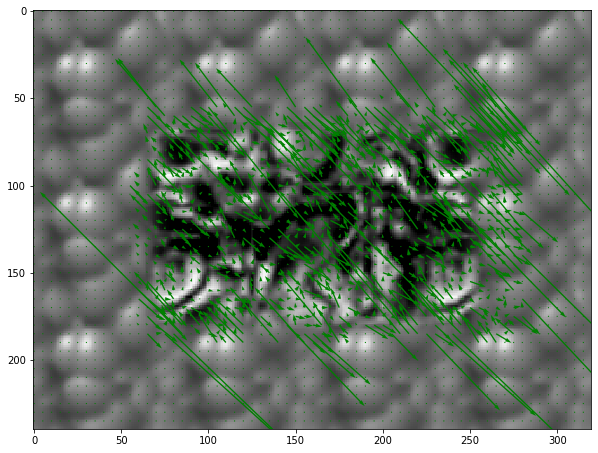

In [29]:
LK_image(test_origin, test_shiftR20, 2, 2, 5)

/Users/sifeili/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


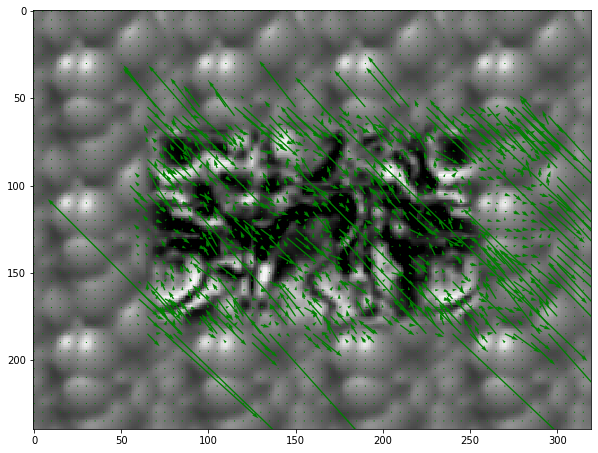

In [30]:
LK_image(test_origin, test_shiftR40, 2, 3, 5)

The results for shiftR10, R20 and R40 were less good than the small pixel displacement with the same kernel for blurring.

Next you’ll try it on the two Data sequences. You’ll need to determine a level of the pyramid where it seems to work. To test your results you should use the recovered motion field to warp the second image back to the first (or the first to the second).

The challenge in this is to create a Warp function and then use it correctly. This is going to be somewhat tricky. I suggest you try and use the test sequence or some simple motion sequence you create where it’s clear that a block is moving in a specific direction. The first question is are you recovering the amount you need to move to bring the second image to the first or the first to the second. If you look carefully at the slides you’ll see we’re solving for the amount that is the change from I1 to I2 Consider a case the image moves 2 pixels to the right. This means that I2(5, 7) = I1(3, 7) where I am indexing by x, y and not by row and column. So to warp I2 back to I1 to create a new image W, would set W(x,y) to the value of I2(x+2,y). The W would align with I1.
MATLAB has a function to do this interpolation: INTERP2. To use this, you’ll need to understand the function MESHGRID - which tends to think about matrices as X and Y not rows and columns. So the call:

[M,N]=size(i2);

[x,y]=meshgrid(1:N,1:M);

creates a matrix called x which is just repeated columns of the x value - the column index, and y istherowindex. Inthiscase,ifM-thenumberofrows-is4andNis3,thenxandyare4x3. This can be confusing. Another way to think about it is that these are the x and y values(column and row) of the (i,j) locations. So if you want to get a value from somewhere near by in the image, you would add the displacement to this value. This can be seen in the following very good warp function (courtesy Yair Weiss when still a student):

    function [warpI2]=warp(i2,vx,vy)
       % warp i2 according to flow field in vx vy
       % this is a "backwards" warp: if vx,vy are correct then warpI2==i1
       [M,N]=size(i2);
       [x,y]=meshgrid(1:N,1:M);
       warpI3=interp2(x,y,i2,x+vx,y+vy,’*nearest’); % use Matlab interpolation routine
       warpI2=interp2(x,y,i2,x+vx,y+vy,’*linear’); % use Matlab interpolation routine
       I=find(isnan(warpI2));
       warpI2(I)=warpI3(I);
   
In OpenCV there is the function remap which behaves similarly.

In [36]:
def warp(img1, u, v):
    map_x = (img1 + u).astype(np.float32)
    map_y = (img1 + v).astype(np.float32)
    out_img = cv2.remap(img1, map_x, map_y, interpolation=cv2.INTER_CUBIC)
    return out_img

2.3 Apply your single-level LK code to theDataSeq1 sequence (from 1 to 2 and 2 to 3). Because LK only works for small displacements, find a Gaussian pyramid level that works for these. To show that it works, you will show the output flow fields as above and you’ll show a warped version of image 2 to the coordinate system of image 1. That is, you’ll warp Image 2 back into alignment with image 1. If you flicker (rapidly show them back and forth) the warped image 2 and the original image 1, you should see almost no motion: the second image pixels have been ”moved back” to the location they came from in the first image. Same is true for image 2 to 3. Next try this for DataSeq2 where the displacements are greater. You will likely need to use a coarser level in the pyramid (more blurring) to work for this one.

Note: for this question you are only comparing between images at some chosen level of the pyramid! In the next section you’ll do the hierarchy.

Output: The code and the images showing the x and y displacements for DataSeq1 and DataSeq2 either as images or as arrows. Then, for each sequence, show the ***difference*** image between the warped image 2 and the original image 1.

/Users/sifeili/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


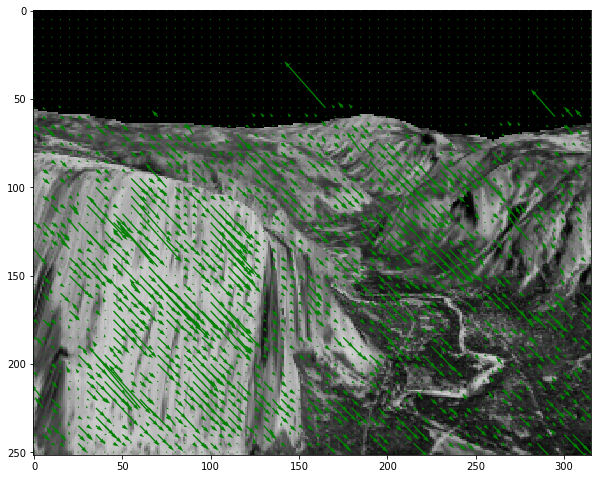

In [24]:
LK_image(seq1_imgs[0], seq1_imgs[1], 3, 1, 5)

In [32]:
u1, v1 = LK(seq1_imgs[0], seq1_imgs[1], 5)

/Users/sifeili/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [40]:
out1 = warp(seq1_imgs[0], u1, v1)
diff1 = abs(seq1_imgs[1] - out1)
out_diff1 = cv2.hconcat([out1, diff1])
cv2.imwrite('ps5-2-3-2.png', out_diff1)

True

![ps5-2-3-2](./ps5-2-3-2.png)

/Users/sifeili/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


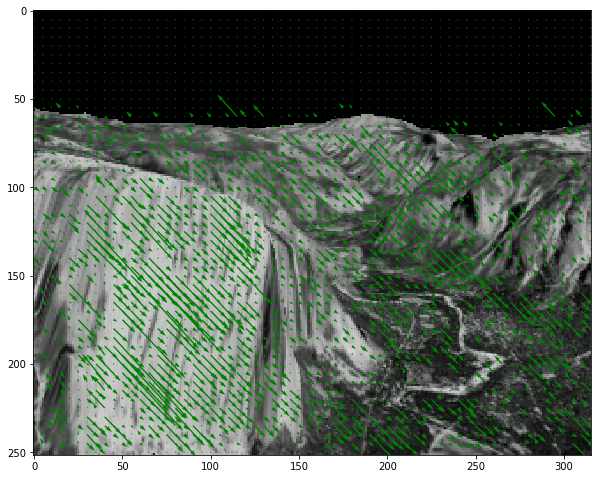

In [41]:
LK_image(seq1_imgs[1], seq1_imgs[2], 3, 3, 5)

In [42]:
u2, v2 = LK(seq1_imgs[1], seq1_imgs[2], 5)

/Users/sifeili/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [54]:
out2 = warp(seq1_imgs[1], u2, v2)
diff2 = seq1_imgs[2] - out2
out_diff2 = cv2.hconcat([out2, diff2])
cv2.imwrite('ps5-2-3-4.png', out_diff2)

True

![ps5-2-3-4](./ps5-2-3-4.png)

In [46]:
seq2_imgs = []
for img in glob.glob(r'./images/DataSeq2/*.png'):
    gray_img = cv2.imread(img)
    gray_img = cv2.cvtColor(gray_img, cv2.COLOR_BGR2GRAY)
    seq2_imgs.append(gray_img)

/Users/sifeili/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


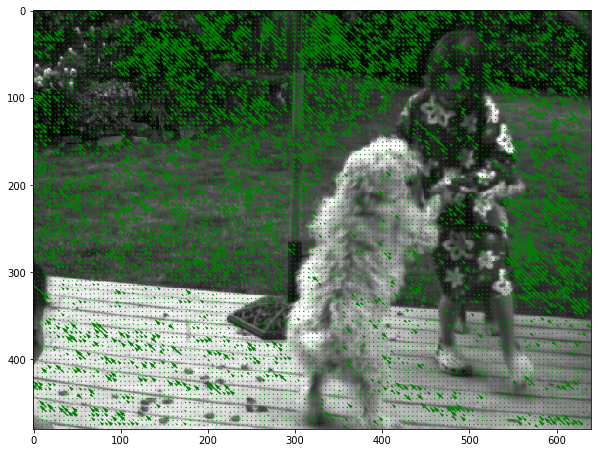

In [47]:
LK_image(seq2_imgs[0], seq2_imgs[1], 3, 5, 5)

In [49]:
u3, v3 = LK(seq2_imgs[0], seq2_imgs[1], 5)

/Users/sifeili/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [50]:
out3 = warp(seq2_imgs[0], u3, v3)
diff3 = abs(seq2_imgs[1] - out3)
out_diff3 = cv2.hconcat([out3, diff3])
cv2.imwrite('ps5-2-3-6.png', out_diff3)

True

![ps5-2-3-6](./ps5-2-3-6.png)

/Users/sifeili/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


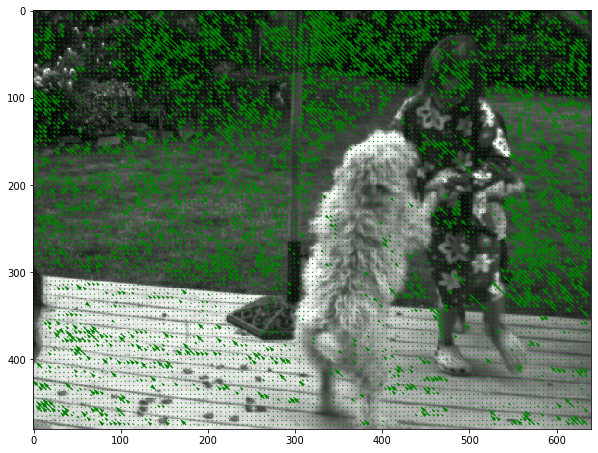

In [51]:
LK_image(seq2_imgs[1], seq2_imgs[2], 3, 7, 5)

In [52]:
u4, v4 = LK(seq2_imgs[1], seq2_imgs[2], 5)

/Users/sifeili/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [53]:
out4 = warp(seq2_imgs[1], u4, v4)
diff4 = seq2_imgs[2] - out4
out_diff4 = cv2.hconcat([out4, diff4])
cv2.imwrite('ps5-2-3-8.png', out_diff4)

True

![ps5-2-3-8](./ps5-2-3-8.png)

**There is a brightness change in the warped image, which I was not able to correct, that leads to a difference between the warped image and the next image in the sequence


3 Hierarchical LK optic flow

Recall that the basic steps of the hierarchy:
1. Given input images L and R. Initialize k = n where n is the max level.
2. REDUCE both input images to level k. Call these images Lk and Rk.
3. If k = n initialize U and V to be zero images the size of Lk; otherwise expand the flow field and double (why?) to get to the next level: U = 2*EXPAND(U), V =2* EXPAND(V).
4. Warp Lk using U and V to form Wk.
5. Perform LK on Wk and Rk to yield two incremental flow fields Dx and Dy.
6. Add these to original flow: U = U + Dx and V = V + Dy.
7. Ifk>0letk=k−1andgoto(2).
8. Return U and V .

When developing this code you should try it on TestSeq between the base and the larger shifts, or you might try and create some test sequences of your own. Take a textured image and displace a center square by a fixed translation amount. Vary the amount and make sure your hierarchical method does the right thing. In principle, for a displacement of δ pixels, you’ll need to set n to (at least) log2(δ).

3.1 Write the function to compute the hierarchical LK (surprised, huh?). First apply to the TestSeq for the displacements of 10, 20 and 40 pixels. Then apply to both DataSeq1 and DataSeq2.

Output: The code, the displacement images and the difference image between the warped I2 and the original I1 for each of the cases.

In [55]:
def hierarchical_LK(img1, img2, level, win_size=5):
   # Given input images L and R. Initialize k = n where n is the max level.
    k = level
    while k > 0:
        # REDUCE both input images to level k. Call these images Lk and Rk.
        Lk = pyramid_reduce(img1, k)[-1]
        Rk = pyramid_reduce(img2, k)[-1]
        # If k = n initialize U and V to be zero images the size of Lk; otherwise expand the flow field and double 
        # (why?) to get to the next level: U = 2EXPAND(U), V =2 EXPAND(V).
        if k == level:
            U = np.zeros((Lk.shape))
            V = np.zeros((Lk.shape))
        else:
            U = np.repeat(U, 2, axis=1)
            U = np.repeat(U, 2, axis=0)
            V = np.repeat(V, 2, axis=1)
            V = np.repeat(V, 2, axis=0)
        U = U[:len(Lk), :len(Lk[0])]
        V = U[:len(Lk), :len(Lk[0])]
        # Warp Lk using U and V to form Wk.
        Wk = warp(Lk, U, V)
        # Perform LK on Wk and Rk to yield two incremental flow fields Dx and Dy.
        Dx, Dy = LK(Lk, Rk, win_size=win_size)
        # Add these to original flow: U = U + Dx and V = V + Dy.
        U = U + Dx
        V = V + Dy
        # Ifk>0letk=k−1andgoto(2).
        k -= 1
    # Return U and V .
    return U, V

In [56]:
def hierarchical_LK_image(img1, img2, level=4, n0=3, n1=1, n2=1, win_size=5):
    u, v = hierarchical_LK(img1, img2, level=level, win_size=win_size)
    out_img = img1.copy()
    out_img = cv2.cvtColor(out_img, cv2.COLOR_GRAY2BGR)
    fig, ax = plt.subplots(1, figsize=(7,7))
    ax.imshow(out_img)
    X = np.arange(0, img1.shape[1])
    Y = np.arange(0, img1.shape[0])
    ax.quiver(X[::5], Y[::5], u[::5, ::5], v[::5, ::5], color='g')
    plt.savefig('ps5-{}-{}-{}.png'.format(n0, n1, n2))

/Users/sifeili/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


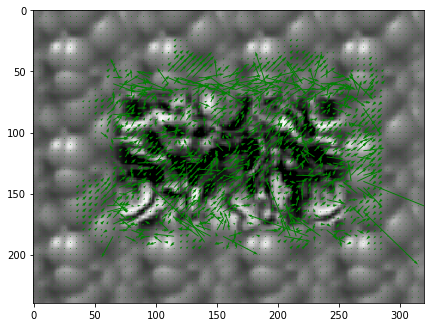

In [57]:
hierarchical_LK_image(test_origin, test_shiftR10, level=4, n0=3, n1=1, n2=1)

/Users/sifeili/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


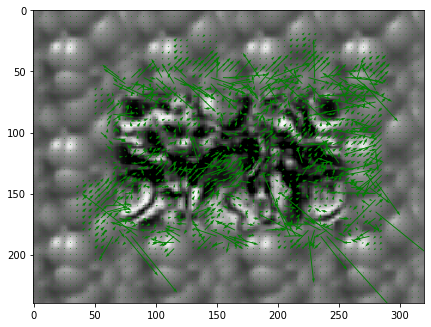

In [58]:
hierarchical_LK_image(test_origin, test_shiftR20, level=4, n0=3, n1=1, n2=2)

/Users/sifeili/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


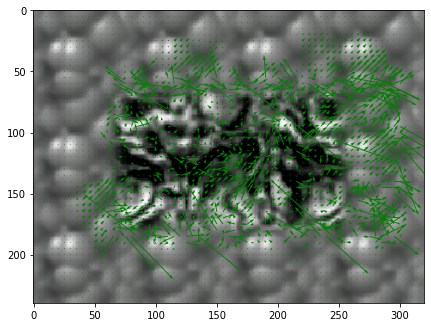

In [59]:
hierarchical_LK_image(test_origin, test_shiftR40, level=4, n0=3, n1=1, n2=3)

4 The Juggle Sequence

The sequence Juggle has significant displacement between frames — the juggled balls move signif- icantly. Try your hierarchical LK on that sequence and see if you can warp frame 2 back to frame 1.

4.1 Apply your hierarchical LK to the Juggle sequence.

Output: Displacement image (as image or quiver diagram) and the difference image between
the warped I2 and the original I1.

In [60]:
juggle_imgs = []
for img in glob.glob(r'./images/Juggle/*.png'):
    gray_img = cv2.imread(img)
    gray_img = cv2.cvtColor(gray_img, cv2.COLOR_BGR2GRAY)
    juggle_imgs.append(gray_img)

/Users/sifeili/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


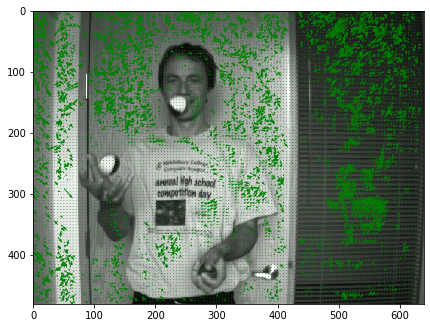

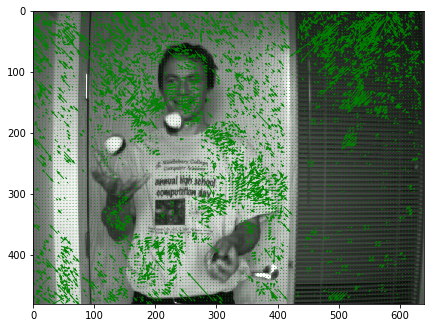

In [61]:
for i in range(len(juggle_imgs) - 1):
    hierarchical_LK_image(juggle_imgs[i], juggle_imgs[i+1], level=4, n0=4, n1=1, n2=i+1)

5 The Taxi Sequence

The sequence taxi has distinct moving objects. Use the output of hierarchical LK to create a segmentation of the scene. A segmentation would be a set of image regions where the motion all belongs to the same parametric flow, like translation (all pixels with same velocity) or similarity (pixels movement is determined by 4 coefficients and the < x, y > value of the pixel.

5.1 Apply your hierarchical LK to the taxi sequence and then generate a segmentation map based upon consistent motion in the regions. State your model (translation, similarity, affine, or what?)

In [62]:
taxi_imgs = []
for img in glob.glob(r'./images/Taxis/*.jpg'):
    taxi_imgs.append(cv2.imread(img, cv2.COLOR_BGR2GRAY))

/Users/sifeili/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


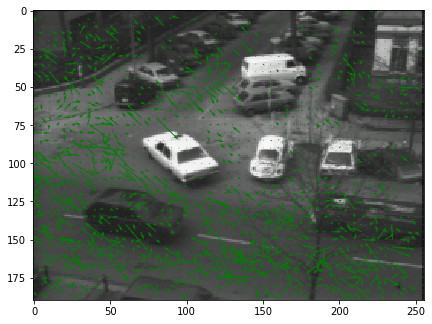

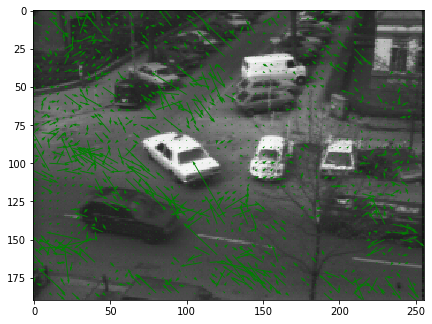

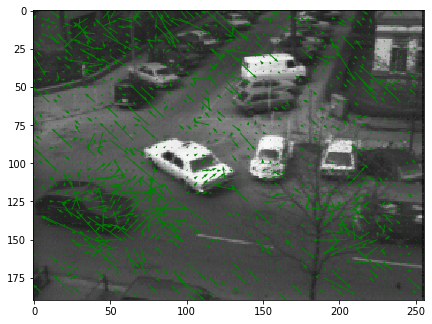

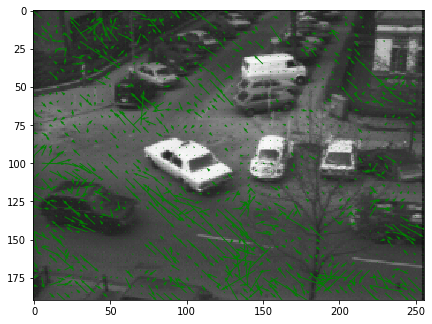

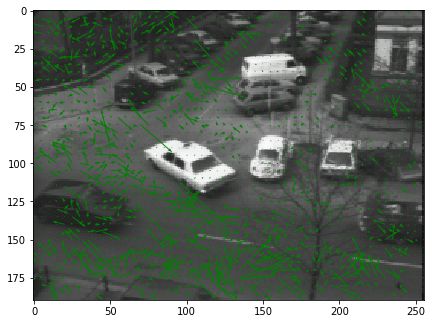

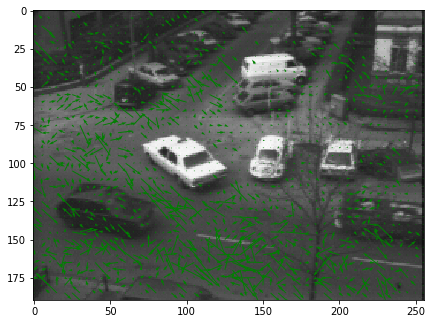

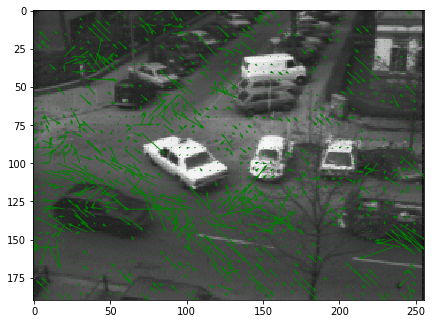

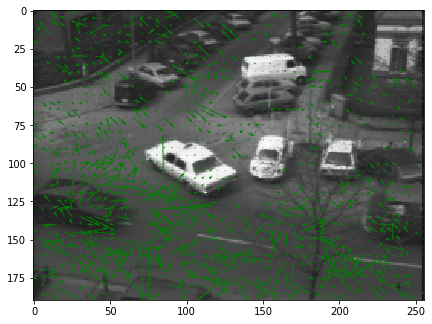

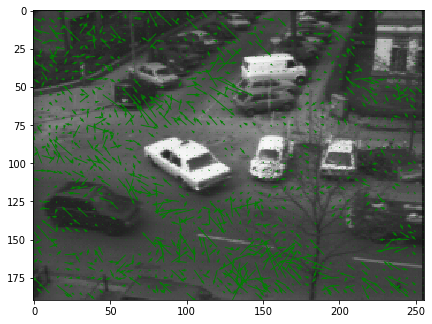

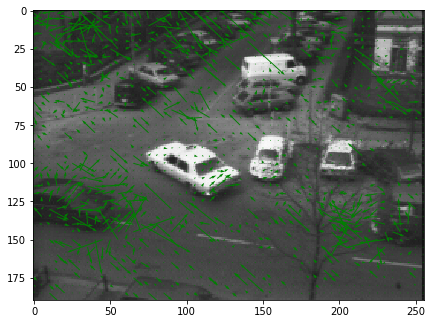

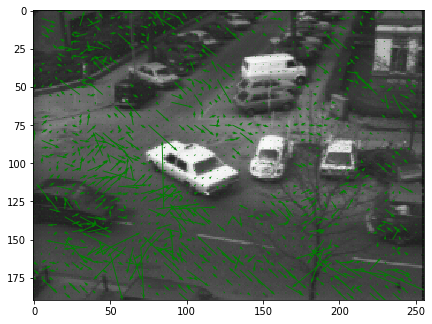

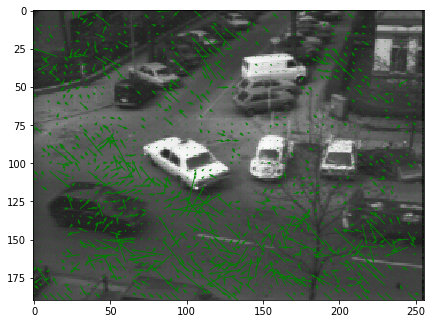

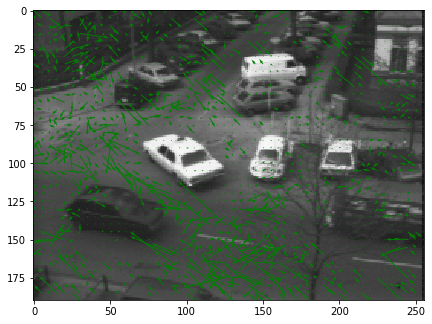

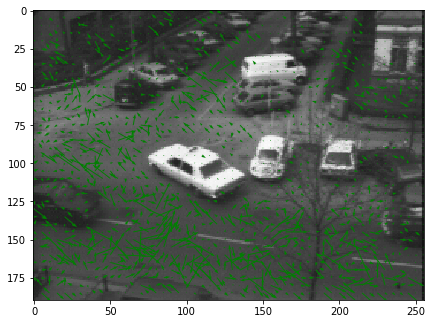

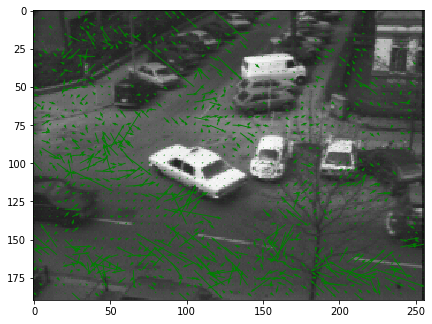

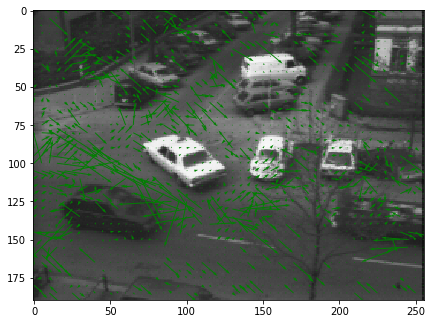

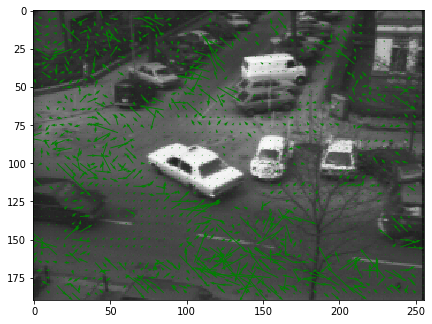

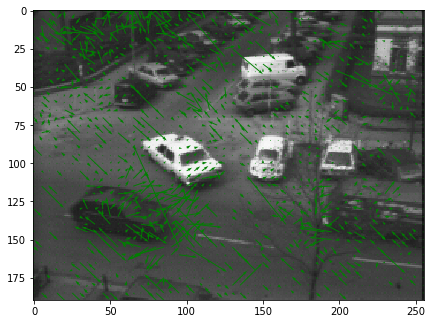

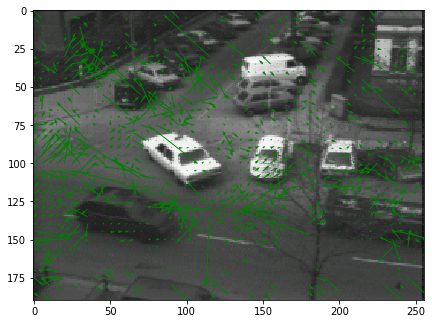

In [63]:
for i in range(len(taxi_imgs) - 1):
    hierarchical_LK_image(taxi_imgs[i], taxi_imgs[i+1], level=4, n0=5, n1=1, n2=i+1)